In [22]:
import copy
from typing import Set, Tuple, Optional
from math import log, pi

import pandas as pd
import numpy as np
import zipfile
import re

from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
from covariance_selection_algorithm import calculate

In [44]:
archive = zipfile.ZipFile('wine-quality.zip', 'r')
name = archive.namelist()

print(name)

['wineQualityReds.csv', 'wineQualityWhites.csv']


In [45]:
data = pd.read_csv(archive.open(name[1]))
data = data.drop(['Unnamed: 0'], axis=1)

print(data.columns)

Index(['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar',
       'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [46]:
data.columns = ['фиксированная кислотность', 'летучая кислотность', 'лимонная кислота', 
                'остаточный сахар', 'хлориды', 'свободный диоксид серы', 
                'общий диоксид серы', 'плотность',
                'pH', 'сульфаты', 'спирт', 'качество']

In [47]:
%%time

X = spearmanr(data) #approx n^3

CPU times: user 8.58 ms, sys: 3.59 ms, total: 12.2 ms
Wall time: 10.8 ms


In [28]:
names = data.columns

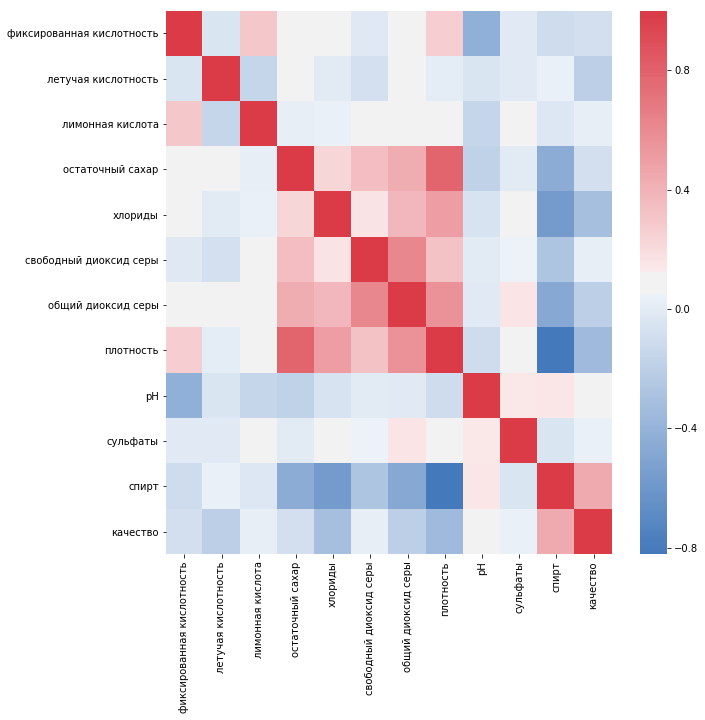

In [29]:
plt.figure(figsize=(10, 10))

sns.heatmap(X[0], cmap=sns.diverging_palette(250, 10, as_cmap=True), 
            xticklabels=names, yticklabels=names)
plt.show()

In [30]:
%%time

A = calculate(X[0], 0.5)

CPU times: user 2.01 s, sys: 10.6 ms, total: 2.02 s
Wall time: 2.03 s


In [31]:
cor_inv = np.linalg.inv(A)
cor = np.triu(X[0])
cor_est = np.triu(A)

for i in range(cor.shape[0]):
    for j in range(cor.shape[0]):
        if np.round(cor_inv[i,j], 4) == 0:
            cor[i,j] = 0
        else:
            cor[i,j] = cor[i,j]    

In [32]:
from IPython.core.display import display, HTML
from string import Template

edges = []

for i in range(cor.shape[0]):
    for j in range(cor.shape[0]):
        if abs(round(cor[i,j], 2)) > 0.2:
            if i!=j:
                item = {'from': i, 'to': j, 'weight': cor[i,j]}
                edges.append(item)

node = list(set([list(e.values())[0] for e in edges] + [list(e.values())[1] for e in edges]))

In [33]:
nodes = []

for i in range(len(node)):
    item = {'id': node[i], 'label': names[node[i]]}
    nodes.append(item)

In [34]:
from IPython.display import Javascript
import json

# Transform the graph into a JSON graph
data = {"nodes":nodes, "edges":edges}
jsonGraph = json.dumps(data, indent=4)

# Send to Javascript
Javascript("""window.jsonGraph={};""".format(jsonGraph))

<IPython.core.display.Javascript object>

In [35]:
%%html
<div id="mynetwork"></div>

In [36]:
%%javascript
requirejs.config({
    paths: {
        vis: 'vis'
    }
});

require(['vis'], function(vis){
    
    // create a network
    var container = document.getElementById('mynetwork');
    var options = {
        width: '800px',
        height: '400px',
        layout: {hierarchical:{enabled:true,
        levelSeparation: 80,
        nodeSpacing: 100,
        treeSpacing: 200,}},
        edges:{
            scaling:{
      min: 1,
      max: 1500,
      label: {
        enabled: true,
        min: 1,
        max: 90,
        maxVisible: 3,
        drawThreshold: 5
      },
      customScalingFunction: function (min,max,total,weight) {
        if (max === min) {
          return 0.5;
        }
        else {
          var scale = 1 / (max - min);
          return Math.max(0,(value - min)*scale);
        
        }}}},
    };
    
    // We load the JSON graph we generated from iPython input
    var graph = window.jsonGraph;
    
    // Display Graph
    var network = new vis.Network(container, graph, options);
});

<IPython.core.display.Javascript object>

In [37]:
import h2o
from h2o.automl import H2OAutoML

In [38]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.2" 2019-01-15 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.2+9-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.2+9-LTS, mixed mode)
  Starting server from /Users/tzobnina/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/js/_ptc5y4d7xn3zms2bjrkbcr40000gn/T/tmpn53z2ten
  JVM stdout: /var/folders/js/_ptc5y4d7xn3zms2bjrkbcr40000gn/T/tmpn53z2ten/h2o_tzobnina_started_from_python.out
  JVM stderr: /var/folders/js/_ptc5y4d7xn3zms2bjrkbcr40000gn/T/tmpn53z2ten/h2o_tzobnina_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Asia/Yekaterinburg
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.5
H2O cluster version age:,1 month and 12 days
H2O cluster name:,H2O_from_python_tzobnina_if6ele
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [39]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [48]:
hdf = h2o.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [49]:
train, test, valid = hdf.split_frame(ratios=[.7, .15])

In [50]:
x = list(names)
y = 'качество'
x.remove(y)

In [51]:
glm_model = H2OGeneralizedLinearEstimator(family= "gaussian", lambda_ = 0, compute_p_values = True)
glm_model.train(x, y, training_frame = hdf)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [52]:
glm_model.model_performance()


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.5631540629886582
RMSE: 0.750435915311
MAE: 0.5836349500279406
RMSLE: 0.11119062263868484
R^2: 0.28187036413327815
Mean Residual Deviance: 0.5631540629886582
Null degrees of freedom: 4897
Residual degrees of freedom: 4886
Null deviance: 3840.9897917515545
Residual deviance: 2758.328600518448
AIC: 11113.480270729757


/Users/tzobnina/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/tzobnina/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/tzobnina/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


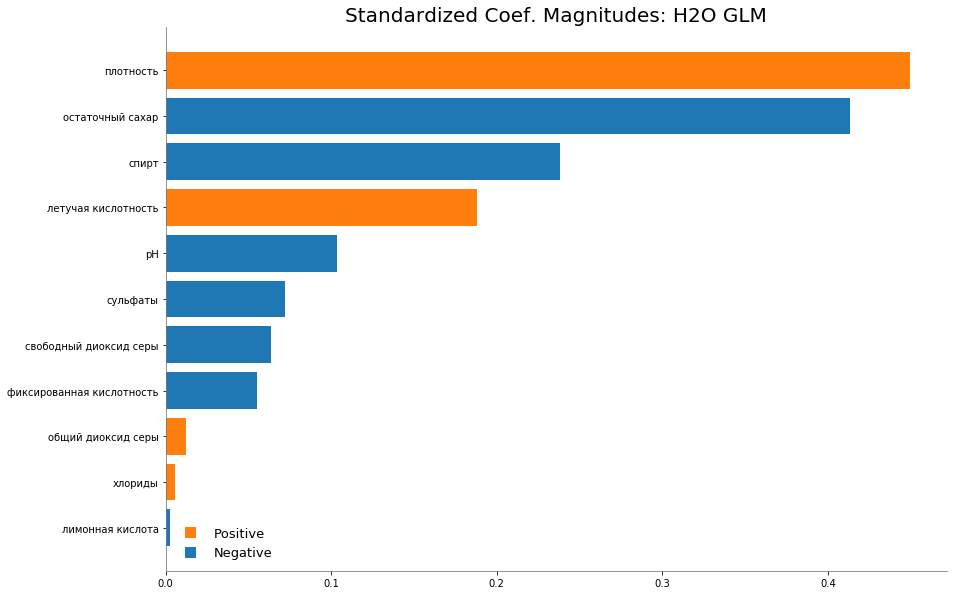

In [55]:
glm_model.std_coef_plot()

In [ ]:
%%time

aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█████████████████████████████████████

In [56]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

NameError: name 'aml' is not defined

In [74]:
m = h2o.get_model(lb[2,"model_id"])
m.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,спирт,3052.572021,1.000000,0.150968
1,летучаякислотность,2551.554688,0.835870,0.126190
2,остаточныйсахар,2095.358398,0.686424,0.103628
3,плотность,2005.687378,0.657048,0.099193
4,свободныйдиоксидсеры,1816.344849,0.595021,0.089829
5,общийдиоксидсеры,1732.650879,0.567604,0.085690
6,лимоннаякислота,1697.979492,0.556246,0.083975
7,фиксированнаякислотность,1686.346069,0.552434,0.083400
8,хлориды,1546.021851,0.506465,0.076460
9,pH,1189.300659,0.389606,0.058818


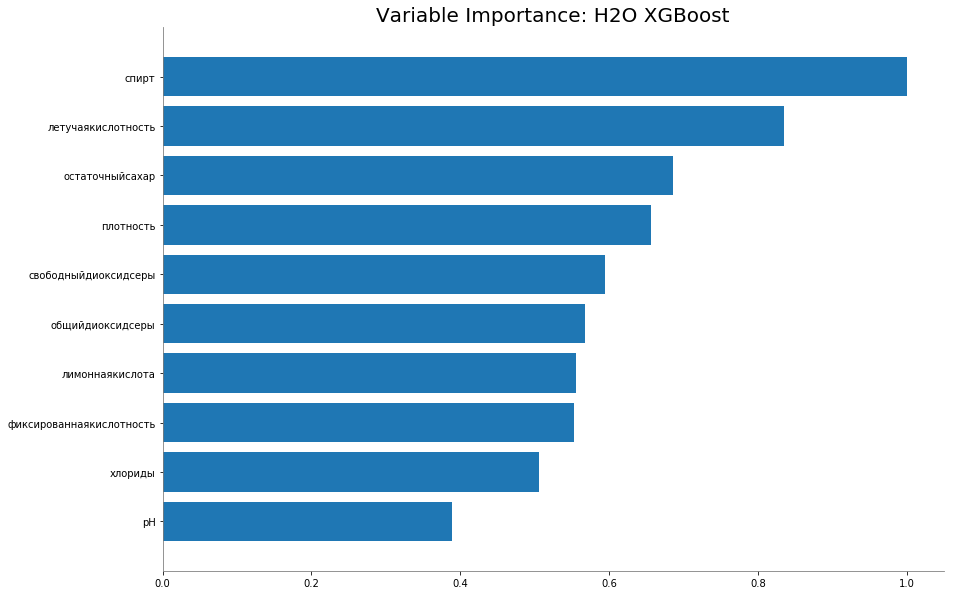

In [75]:
m.varimp_plot()

In [76]:
h2o.shutdown()

[WARNING] in <ipython-input-76-1edf85295eae> line 1:
    >>> h2o.shutdown()
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_8415 closed.
